In [58]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
acquisition_fm4_path = {
    "pre-vib": "previb/20240905_hermes_h4_177Lu_900s_8483.fits",
    "post-vib": "postvib/20240923_1558_hermes_h4_postvib_177lu_900s_lv0d5.fits",
    "post-tvac": "posttvac/20241023_124000_hermes_h4_LV0d5.fits",
}

lu176_201 = 201.83
lu176_306 = 306.78
sources = [lu176_201, lu176_306]

# Payload temperatures

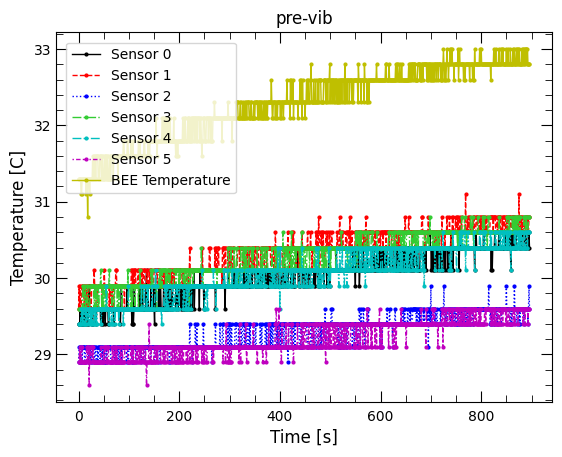

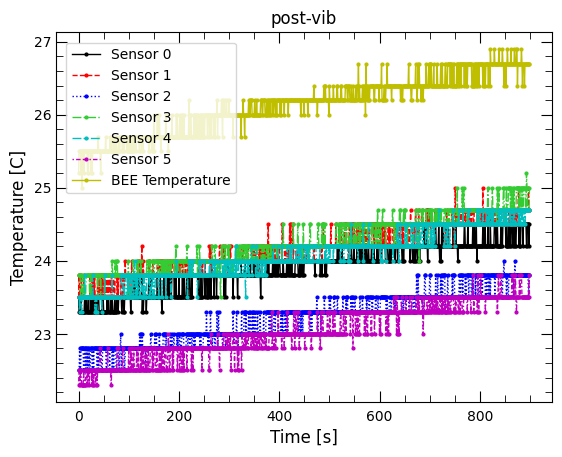

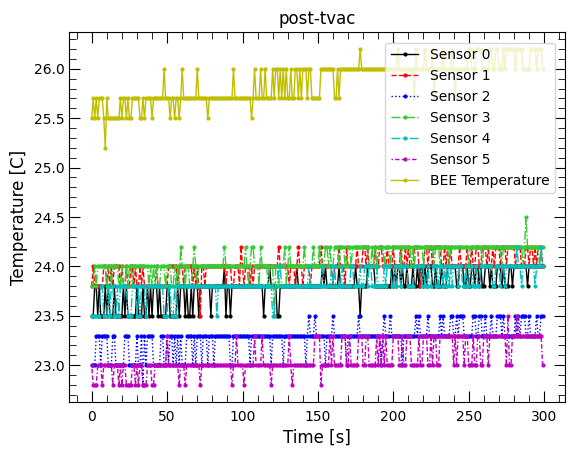

In [60]:
from astropy.io import fits

for label, filepath in acquisition_fm4_path.items():
    with fits.open(filepath) as f:
        hk_data = f[1].data
    
    temp_array = np.hstack((hk_data["FEETEMPP"], np.expand_dims(hk_data["BEETEMPP"], axis=1)))
    temp_df = pd.DataFrame(temp_array, columns=[f"Sensor {i}" for i in range(6)] + ["BEE Temperature"])
    temp_df.plot(ylabel="Temperature [C]", xlabel="Time [s]", marker="o", title=f"{label}", kind="line", ms=2)
    plt.show()


In [61]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_lv0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return

    def log(self, msg):
        pass

configuration = {"xbinning": 10, "sbinning": 10}
model="fm4"

sdd_calibration = read_sdd_calibration_report(Path("calibs/standard/report_cal.xlsx"))
slo_calibration = read_lightout_report(Path("calibs/standard/report_slo.xlsx"))

sdd_previb_calib = read_sdd_calibration_report(Path("calibs/previb/report_cal.xlsx"))
slo_previb_calib = read_lightout_report(Path("calibs/previb/report_slo.xlsx"))

sdd_postvib_calib = read_sdd_calibration_report(Path("calibs/postvib/report_cal.xlsx"))
slo_postvib_calib = read_lightout_report(Path("calibs/postvib/report_slo.xlsx"))


def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_lv0d5(datafile)
    print(f"onto {datafile}..")
    data, waste = preprocess(
        data,
        model=model,
        filter_spurious=True,
        filter_retrigger=20*10**-6,
    )
    calibration = ImportedCalibration(
        model=model,
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )
    return calibration(data), calibration


calibrate_standard = partial(_calibrate_data, model=model, sdd_calibration=sdd_calibration, slo_calibration=slo_calibration, configuration=configuration)
calibrate_previb = partial(_calibrate_data, model=model, sdd_calibration=sdd_previb_calib, slo_calibration=slo_previb_calib, configuration=configuration)
calibrate_postvib = partial(_calibrate_data, model=model, sdd_calibration=sdd_postvib_calib, slo_calibration=slo_postvib_calib, configuration=configuration)

In [62]:
dataframes = {label: calibrate_standard(datafile) for label, datafile in acquisition_fm4_path.items()}

onto previb/20240905_hermes_h4_177Lu_900s_8483.fits..


onto postvib/20240923_1558_hermes_h4_postvib_177lu_900s_lv0d5.fits..


onto posttvac/20241023_124000_hermes_h4_LV0d5.fits..


In [63]:
dfs_previb = {label: calibrate_previb(datafile) for label, datafile in acquisition_fm4_path.items()}

onto previb/20240905_hermes_h4_177Lu_900s_8483.fits..


onto postvib/20240923_1558_hermes_h4_postvib_177lu_900s_lv0d5.fits..


onto posttvac/20241023_124000_hermes_h4_LV0d5.fits..


In [64]:
dfs_postvib = {label: calibrate_postvib(datafile) for label, datafile in acquisition_fm4_path.items()}

onto previb/20240905_hermes_h4_177Lu_900s_8483.fits..


onto postvib/20240923_1558_hermes_h4_postvib_177lu_900s_lv0d5.fits..


onto posttvac/20241023_124000_hermes_h4_LV0d5.fits..


# Maps

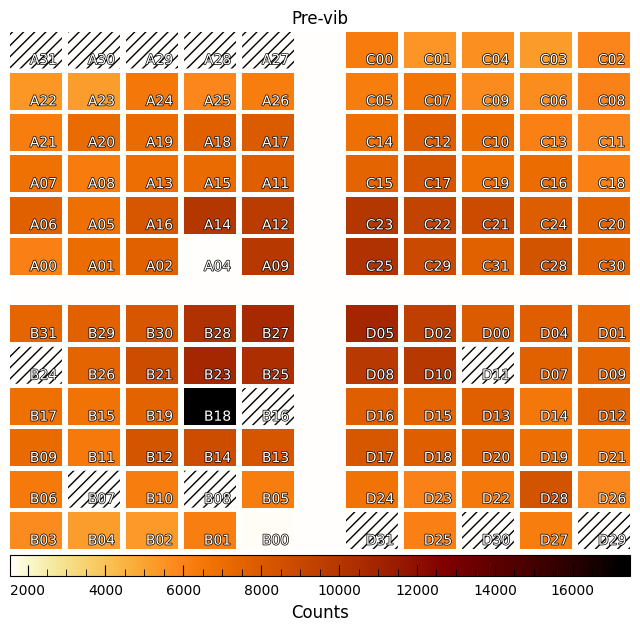

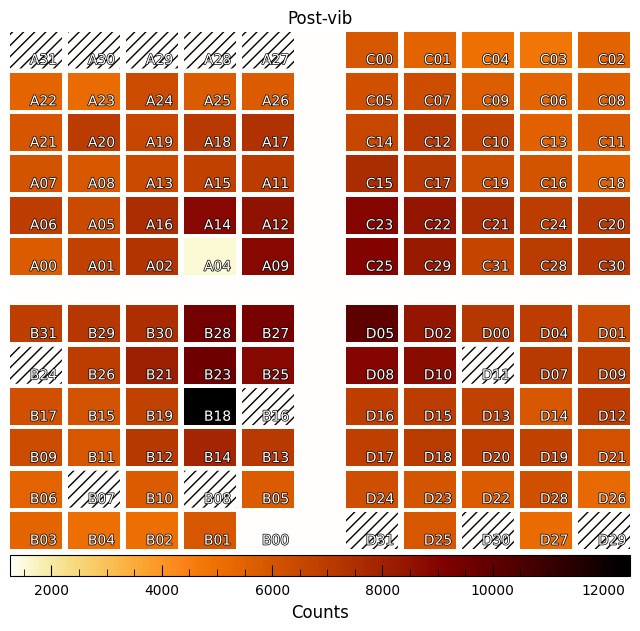

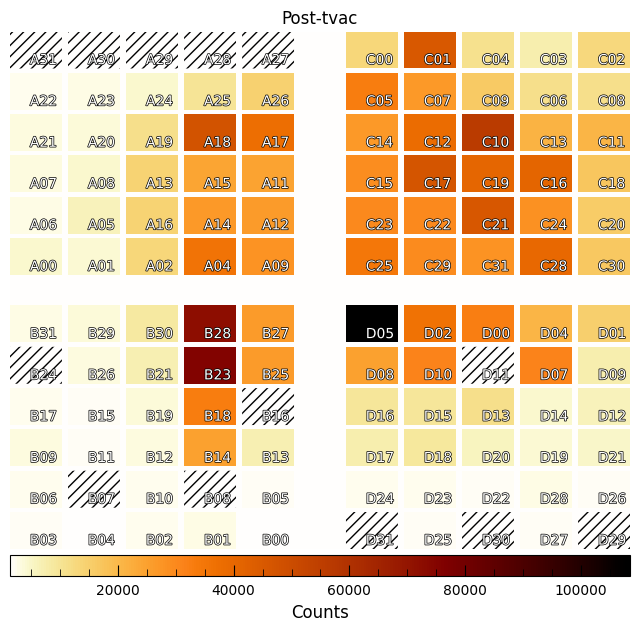

In [65]:
from source.io import pandas_from_lv0d5
from source.plot import mapcounts
from source.calibrate import perchannel_counts
from source.detectors import Detector

dmap = Detector("fm4").map

df = pandas_from_lv0d5(acquisition_fm4_path["pre-vib"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Pre-vib")

df = pandas_from_lv0d5(acquisition_fm4_path["post-vib"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Post-vib")

df = pandas_from_lv0d5(acquisition_fm4_path["post-tvac"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Post-tvac")
calibrate_posttvac = partial(_calibrate_data, model=model, sdd_calibration=sdd_postvib_calib, slo_calibration=slo_postvib_calib, configuration=configuration)


# Spectra

In [66]:
def histogram(data):
    bins = np.arange(50, 1500, .5)
    midpoints = (bins[:-1] + bins[1:]) / 2
    return np.histogram(data["ENERGY"], bins=bins)[0], midpoints

In [67]:
from astropy.io import fits
from scipy.interpolate import interp1d

with fits.open("calibs/hermes_mixedsplice.fits") as content:
    corr_factor = content[1].data
    f1 = interp1d(corr_factor["ENERGY"], corr_factor["CORRFACTOR"])


# Standard Calibration

We calibrate all the acquisitions with the standard calibration.

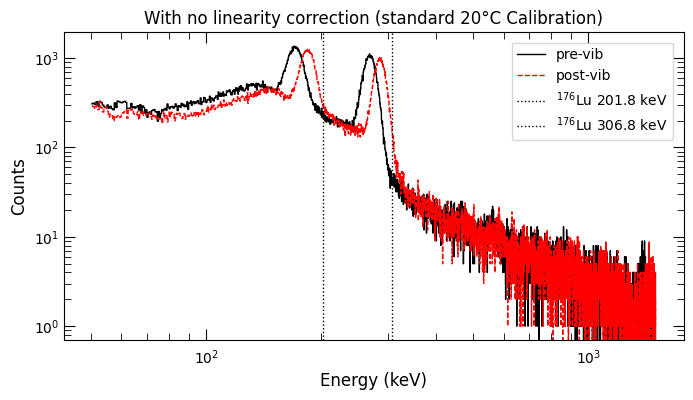

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for label, (data, calibration) in dataframes.items():
    if label == "post-tvac":
        continue # this is miniX2, not worth checking it here
    counts, midpoints = histogram(data) 
    ax.step(midpoints, counts, where="mid", label=label)
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("With no linearity correction (standard 20°C Calibration)")
plt.show()

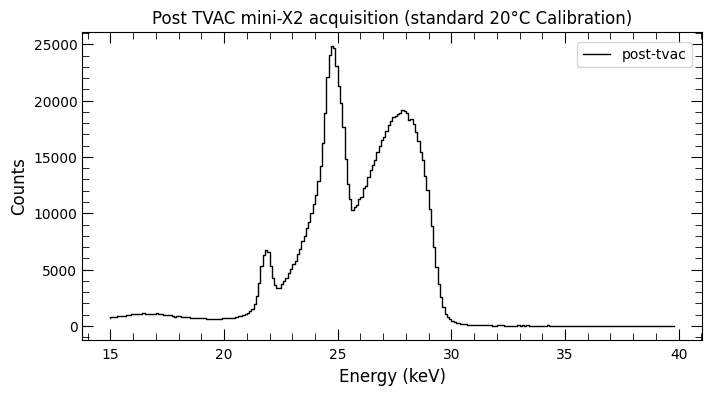

In [69]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for label, (data, calibration) in dataframes.items():
    if label != "post-tvac":
        continue # this is miniX2, not worth checking it here
    counts, bins = np.histogram(data["ENERGY"], bins=np.arange(15, 40, 0.1)) 
    ax.step(bins[:-1], counts, label=label)
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("Post TVAC mini-X2 acquisition (standard 20°C Calibration)")
plt.show()

The discrepancy is due temperature and is not solved applying non-linearity correction.

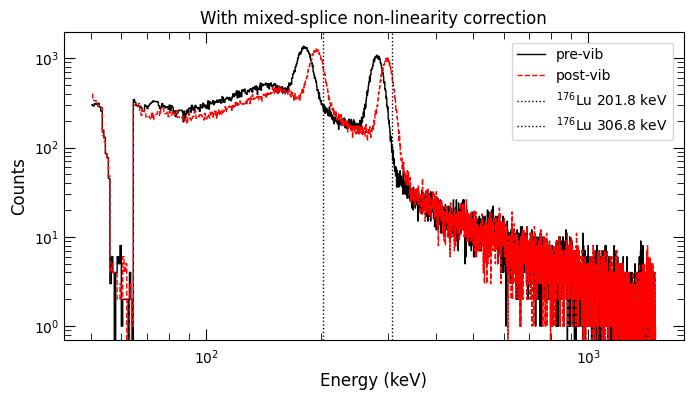

In [70]:
def get_mask(df):
    return (df["ENERGY"] > 10) & (df["EVTYPE"] == "S") & (df["ENERGY"] < 1999.90)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for label, (data, calibration) in dataframes.items():
    if label == "post-tvac":
        continue # this is miniX2, not worth checking it here
    data = {"ENERGY": data[get_mask(data)]["ENERGY"] / f1(data[get_mask(data)]["ENERGY"])}
    counts, midpoints = histogram(data)
    ax.step(midpoints, counts, where="mid", label=f"{label}")
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("With mixed-splice non-linearity correction")
plt.show()

These are the spectra obtained with ad-hoc calibrations obtained mixing the standard SDD calibration and light-output calibration from the 176Lu acquisitions themselves.

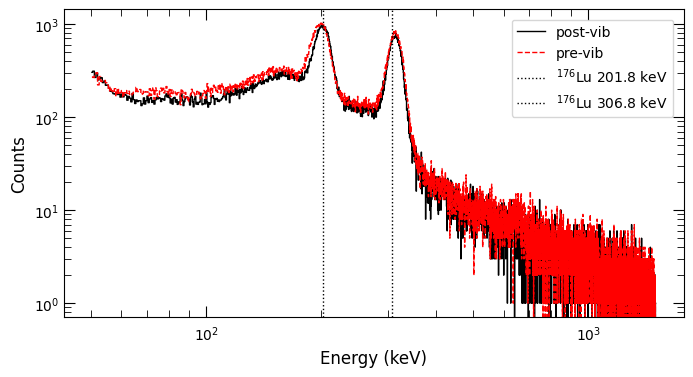

In [74]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
label = "post-vib"
data, calibration = dfs_postvib[label]
counts, midpoints = histogram(data) 
ax.step(midpoints, counts, where="mid", label=label)
label = "pre-vib"
data, calibration = dfs_previb[label]
counts, midpoints = histogram(data) 
ax.step(midpoints, counts, where="mid", label=label)
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.show()


# Changes in light output

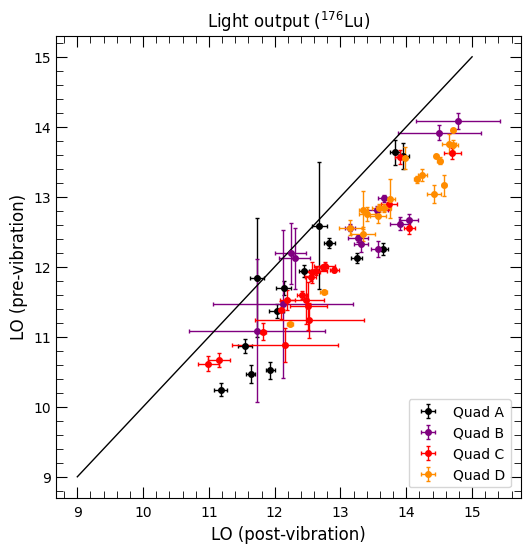

In [72]:
plt.subplots(1, 1, figsize=(6,6))
for quad, color in zip("ABCD",["black", "purple", "red", "darkorange"]):
    indeces = slo_previb_calib[quad]["light_out"].index.intersection(slo_postvib_calib[quad]["light_out"].index)
    plt.errorbar(
        slo_postvib_calib[quad]["light_out"][indeces], 
        slo_previb_calib[quad]["light_out"][indeces], 
        xerr=slo_postvib_calib[quad]["light_out_err"][indeces], 
        yerr=slo_previb_calib[quad]["light_out_err"][indeces], 
        c=color, capsize=1.1,
        fmt = "o", label=f"Quad {quad}") 
    for ch in indeces:
        x = slo_postvib_calib[quad]["light_out"].loc[ch]
        y = slo_previb_calib[quad]["light_out"].loc[ch]
xs = np.linspace(9, 15, 100)
plt.plot(xs, xs)
plt.xlabel("LO (post-vibration)")
plt.ylabel("LO (pre-vibration)")
plt.title("Light output ($^{176}$Lu)")
plt.legend(loc = 4)
plt.show()

We can clearly see a trend indicating higher lightoutput post-vibrations, compatibly with the temperature differences (previb hotter).